# 1. Introduction + Set-up

Machine learning has a phenomenal range of applications, including in health and diagnostics. This tutorial will explain the complete pipeline from loading data to predicting results, and it will explain how to build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia. This is especially useful during these current times as COVID-19 is known to cause pneumonia.

This tutorial will explain how to utilize TPUs efficiently, load in image data, build and train a convolution neural network, finetune and regularize the model, and predict results. Data augmentation is not included in the model because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images. For a tutorial on image data augmentation, check out this [tutorial](https://www.kaggle.com/amyjang/tensorflow-data-augmentation-efficientnet).

Run the following cell to load the necessary packages. Make sure to change the Accelerator on the right to `TPU`.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)


Number of replicas: 1
2.1.0


We need a Google Cloud link to our data to load the data using a TPU. While we're at it, we instantiate constant variables. It is generally better practice to use constant variables instead of hard-coding numbers.

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = './dataset'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# 2. Load the data

The Chest X-ray data we are using from [*Cell*](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) divides the data into train, val, and test files. There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the validation files and create a new split that resembes the standard 80:20 division instead.

In [3]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

Run the following cell to see how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have.

In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1078
Pneumonia images count in training set: 3107


Notice that the there are way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data. We will correct for this imbalance later on in our notebook.

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'./dataset/chest_xray/train/PNEUMONIA/person600_virus_1156.jpeg'
b'./dataset/chest_xray/train/NORMAL/NORMAL2-IM-0913-0001.jpeg'
b'./dataset/chest_xray/train/PNEUMONIA/person102_virus_189.jpeg'
b'./dataset/chest_xray/train/PNEUMONIA/person1496_bacteria_3909.jpeg'
b'./dataset/chest_xray/train/PNEUMONIA/person348_bacteria_1602.jpeg'


Run the following cell to see how many images we have in our training dataset and how many images we have in our validation set. Verify that the ratio of images is 80:20.

In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


As expected, we have two labels for our images.

In [7]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

Currently our dataset is just a list of filenames. We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Let's visualize the shape of an (image, label) pair.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


Load and format the test data as well.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

# 3. Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in numpy arrays as its parameters, call the numpy function on the batches to return the tensor in numpy array form.

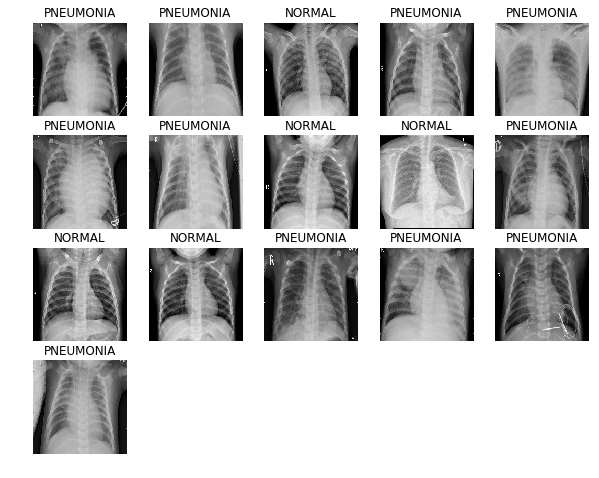

In [17]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. Build the CNN

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

The architecture for this CNN has been inspired by this [article](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8).

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

The following method will define the function to build our model for us. The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer of one node, as this will be the output that determines if an X-ray shows an image of pneumonia.

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. Correct for data imbalance

We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [21]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05855016])

In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

Class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

# 6. Train the model

Since there are only two possible labels for the image, we will be using the `binary_crossentropy` loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [27]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

From exploring the data and the model, I noticed that the training for the model has a slow start. However, after 25 epochs, the model slowly starts to converge.

In [29]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=Class_weight,
)

TypeError: in converted code:

    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2481 _standardize_tensors
        feed_sample_weight_modes)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2480 <listcomp>
        for (ref, sw, cw, mode) in zip(y, sample_weights, class_weights,
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:1004 standardize_weights
        lambda: math_ops.cast(K.reshape(y, (-1,)), dtypes.int64)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/smart_cond.py:59 smart_cond
        name=name)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/control_flow_ops.py:1174 cond
        return cond_v2.cond_v2(pred, true_fn, false_fn, name)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/cond_v2.py:83 cond_v2
        op_return_value=pred)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py:978 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:1003 <lambda>
        lambda: K.argmax(y, axis=1),
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py:2135 argmax
        return math_ops.argmax(x, axis)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/math_ops.py:141 argmax
        return argmax_v2(input, axis, output_type, name)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/math_ops.py:187 argmax_v2
        return gen_math_ops.arg_max(input, axis, name=name, output_type=output_type)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_math_ops.py:849 arg_max
        name=name)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py:576 _apply_op_helper
        param_name=input_name)
    /home/kebab/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py:61 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'input' has DataType bool not in list of allowed values: float32, float64, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, float16, uint32, uint64


# 7. Finetune the model

Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. Finetuning is beyond the scope of this notebook, but check out this [article](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/) for more information.

For our purposes, we'll use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. Since we set `restore_best_weights` to `True`, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

We also want to finetune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

# 8. Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the second round of training. Since we initially trained the model with 30 epochs, these would be epochs 31-45. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

# 9. Predict and evaluate results

Let's evaluate the model on our test data!

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds)

We see that our accuracy on our test data is 83%, which is lower than the accuracy for our validating set. This may indicate overfitting. Try finetuning the model further to decrease overfitting to the training and validation sets.

Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.